# Attentive Latent Neural Process (AttnLNP)

```{figure} ../images/computational_graph_AttnLNPs.svg
---
width: 400em
name: computational_graph_AttnLNPs
alt: Computational graph of AttnLNP
---
Computational graph for Attentive Latent Neural Processes.
```

In this notebook we will show how to train a AttnLNP on samples from GPs and images using our framework, as well as how to make nice visualizations of sampled from AttnLNPs.
We will follow quite closely the previous {doc}`LNP notebook <LNP>` and {doc}`AttnCNP notebook <AttnCNP>`.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as plt
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load all the data. For more details about the data and some samples, see the {doc}`data <Datasets>` notebook.

In [2]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

# DATASETS
# gp
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets()
# image
img_datasets, img_test_datasets = get_img_datasets(["celeba32", "mnist", "zsmms"])

Now let's define the context target splitters, which given a data point will return the context set and target set by selecting randomly selecting some points and preprocessing them so that the features are in $[-1,1]$. 
We use the same as in {doc}`CNP notebook <CNP>`, namely all target points and uniformly sampling in $[0,50]$ and $[0,n\_pixels * 0.3]$ for 1D and 2D respectively.

In [3]:
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs,
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=50), targets_getter=get_all_indcs,
    )
)
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker,
    )
)

# for ZSMMS you need the pixels to not be in [-1,1] but [-1.75,1.75] (i.e 56 / 32) because you are extrapolating
get_cntxt_trgt_2d_extrap = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0, b=0.5),
        target_masker=no_masker,
        upscale_factor=get_test_upscale_factor("zsmms"),
    )
)

Let's now define the models. We use the same architecture as in {doc}`AttnCNP notebook <AttnCNP>`. The only differences are that we replace `AttnCNP` with `AttnLNP`, as a result we will use two paths ({numref}`computational_graph_AttnCNPs`): 
* **Deterministic Path**: this is the same  as in {doc}`AttnCNP notebook <AttnCNP>`.
* **Latent Path**: this is the same as in {doc}`LNP notebook <LNP>`.

As in {doc}`LNP notebook <LNP>` we will train the model using NPVI and thus set `is_q_zCct` to infer the latent variable using BOTH the context and target set (posterior sampling). This also means that when evaluating we will evaluate the log likelihood using posterior sampling.



In [4]:
from functools import partial

from npf import AttnLNP
from npf.architectures import MLP, merge_flat_input
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    is_q_zCct=True,  # will use NPVI => posterior sampling
    n_z_samples_train=1,
    n_z_samples_test=8,  # small number of sampled because Attn is memory intensive
    r_dim=R_DIM,
    attention="transformer",  # multi headed attention with normalization and skip connections
)

# 1D case
model_1d = partial(
    AttnLNP,
    x_dim=1,
    y_dim=1,
    XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM), is_sum_merge=True,
    ),
    is_self_attn=False,
    **KWARGS,
)

# image (2D) case
model_2d = partial(
    AttnLNP, x_dim=2, is_self_attn=True, **KWARGS
)  # don't add y_dim yet because depends on data

n_params_1d = count_parameters(model_1d())
n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (1D): {n_params_1d:,d}")
print(f"Number Parameters (2D): {n_params_2d:,d}")

Number Parameters (1D): 335,170
Number Parameters (2D): 468,486


Note that there are more parameters than in `CNP notebook <CNP>` because of the latent path. 
For more details about all the possible parameters, refer to the docstrings of `AttnLNP`.

In [5]:
# AttnLNP Docstring

print(AttnLNP.__doc__)


    Attentive (latent) neural process [1].

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    LatentEncoder : nn.Module, optional
        Encoder which maps r -> z_suffstat. It should be constructed via
        `LatentEncoder(r_dim, n_out)`.  If `None` uses an MLP.

    kwargs : 
        Additional arguments to `AttnCNP` and `NeuralProcessFamily`.

    References
    ----------
    [1] Kim, Hyunjik, et al. "Attentive neural processes." arXiv preprint
        arXiv:1901.05761 (2019).
    


### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters. As in {doc}`LNP notebook <LNP>` we train the latent variable model with NPVI`ELBOLossLNPF`. 



Computational Notes :
- the following will either train all the models (`is_retrain=True`) or load the pretrained models (`is_retrain=False`)
- the code will use a (single) GPU if available
- decrease the batch size if you don't have enough memory
- 30 epochs should give you descent results for the GP datasets (instead of 100)

In [7]:
import skorch
from npf import ELBOLossLNPF
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=ELBOLossLNPF,  # NPVI
    chckpnt_dirname="results/pretrained/",
    device=None,  # use GPU if available
    batch_size=32,
    lr=1e-3,
    decay_lr=10,  # decrease learning rate by 10 during training
    seed=123,
)


# 1D
trainers_1d = train_models(
    gp_datasets,
    {"AttnLNP": model_1d},
    test_datasets=gp_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)


# 2D
trainers_2d = train_models(
    img_datasets,
    add_y_dim({"AttnLNP": model_2d}, img_datasets),  # y_dim (channels) depend on data
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    datasets_kwargs=dict(
        zsmms=dict(
            iterator_train__collate_fn=get_cntxt_trgt_2d_extrap,
            iterator_valid__collate_fn=get_cntxt_trgt_2d_extrap,
        )
    ),  # for zsmm use extrapolation
    max_epochs=50,
    **KWARGS
)


--- Loading RBF_Kernel/AttnLNP/run_0 ---

RBF_Kernel/AttnLNP/run_0 | best epoch: None | train loss: -166.447 | valid loss: None | test log likelihood: 153.6258

--- Loading Periodic_Kernel/AttnLNP/run_0 ---

Periodic_Kernel/AttnLNP/run_0 | best epoch: None | train loss: 38.7724 | valid loss: None | test log likelihood: -44.8828

--- Loading Noisy_Matern_Kernel/AttnLNP/run_0 ---

Noisy_Matern_Kernel/AttnLNP/run_0 | best epoch: None | train loss: 88.0575 | valid loss: None | test log likelihood: -89.8116

--- Loading Variable_Matern_Kernel/AttnLNP/run_0 ---

Variable_Matern_Kernel/AttnLNP/run_0 | best epoch: None | train loss: -223.9907 | valid loss: None | test log likelihood: -3670.0447

--- Loading All_Kernels/AttnLNP/run_0 ---

All_Kernels/AttnLNP/run_0 | best epoch: None | train loss: 62.6881 | valid loss: None | test log likelihood: -73.8714

--- Loading celeba32/AttnLNP/run_0 ---

celeba32/AttnLNP/run_0 | best epoch: 43 | train loss: -5109.2837 | valid loss: -5339.7405 | test log

### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. We'll reuse the same plotting procedure as in {doc}`LNP notebook <LNP>`.

In [8]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


def multi_posterior_gp_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[0, 2, 5, 7, 10, 15, 20, 30, 50, 100],
        fps=1.2,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=True,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        # Fix formatting for coherent GIF
        plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}
        ),
        seed=seed,
        **kwargs,
    )

Let us visualize samples from the LNP when it is trained on samples from a single GP.

In [9]:
def filter_single_gp(d):
    """Select only data form single GP."""
    return {k: v for k, v in d.items() if ("All" not in k) and ("Variable" not in k)}


multi_posterior_gp_gif(
    "AttnLNP_single_gp",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    n_samples=20,  # 20 samples from the latent
)

```{figure} ../gifs/AttnLNP_single_gp.gif
---
width: 35em
name: AttnLNP_single_gp
alt: AttnLNP on single GP
---

Posterior predictive of AttnLNPs conditioned on 20 different sampled latents (Blue line with shaded area for $\mu \pm \sigma | z$) and the oracle GP (Green line with dashes for $\mu \pm \sigma$) when conditioned on contexts points (Black) from an underlying function sampled from a GP. Each row corresponds to a different kernel and AttnLNP trained on samples for the corresponding GP. 
```

From {numref}`AttnLNP_single_gp` we see that although AttnLNP do not underfit like LNPs ({numref}`LNP_single_gp`). The samples: (i) are not very smooth (the "kinks" seed in {numref}`AttnCNP_single_gp` are even more obvious when sampling); (ii) lack diversity and seem to be shifted versions of each other. In addition AttnLNP will not be able to extrapolate for the same reasons as AttnCNP.

In [9]:
###### ADDITIONAL 1D PLOTS ######

### Extrap ###
multi_posterior_gp_gif(
    "AttnLNP_single_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
    n_samples=20,
)

### Varying hyperparam ###
def filter_hyp_gp(d):
    return {k: v for k, v in d.items() if ("Variable" in k)}


multi_posterior_gp_gif(
    "AttnLNP_vary_gp",
    trainers=filter_hyp_gp(trainers_1d),
    datasets=filter_hyp_gp(gp_test_datasets),
    n_samples=20,
    model_labels=dict(main="Model", generator="Fitted GP")
)

### All kernels ###
# data with varying kernels simply merged single kernels
single_gp_datasets = filter_single_gp(gp_test_datasets)

# use same trainer for all, but have to change their name to be the same as datasets
base_trainer_name = "All_Kernels/AttnLNP/run_0"
trainer = trainers_1d[base_trainer_name]
replicated_trainers = {}
for name in single_gp_datasets.keys():
    replicated_trainers[base_trainer_name.replace("All_Kernels", name)] = trainer

multi_posterior_gp_gif(
    "AttnLNP_kernel_gp",
    trainers=replicated_trainers,
    datasets=single_gp_datasets,
    n_samples=20,
)

#### Image Dataset

Let us now look at images. We again will use the same plotting procedure as in {doc}`LNP notebook <LNP>`.

In [10]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs
from utils.visualize import giffify


def multi_posterior_imgs_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half of the image
            "vhalf",  # vertival half of the image
        ],
        fps=1.2,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=3,  # images per datasets
        is_plot_std=True,  # plot the predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

In [11]:
multi_posterior_imgs_gif(
    "AttnLNP_img", trainers=trainers_2d, datasets=img_test_datasets, n_samples=3,
)

```{figure} ../gifs/AttnLNP_img.gif
---
width: 45em
name: AttnLNP_img
alt: AttnLNP on CelebA, MNIST, ZSMM
---

3 samples (means conditioned on different samples from the latent) of the posterior predictive of a AttnLNP_img for CelebA $32\times32$, MNIST, and ZSMM for different context sets. The last row shows the standard deviation of the posterior predictive corresponding to the last sample.
```

From {numref}`AttnLNP_img` shows descent sampling and good performances when the model does not require generalization (CelebA $32\times32$, MNIST) but breaks for ZSMM.

Here are more samples, corresponding to specific percentiles of the test log loss.

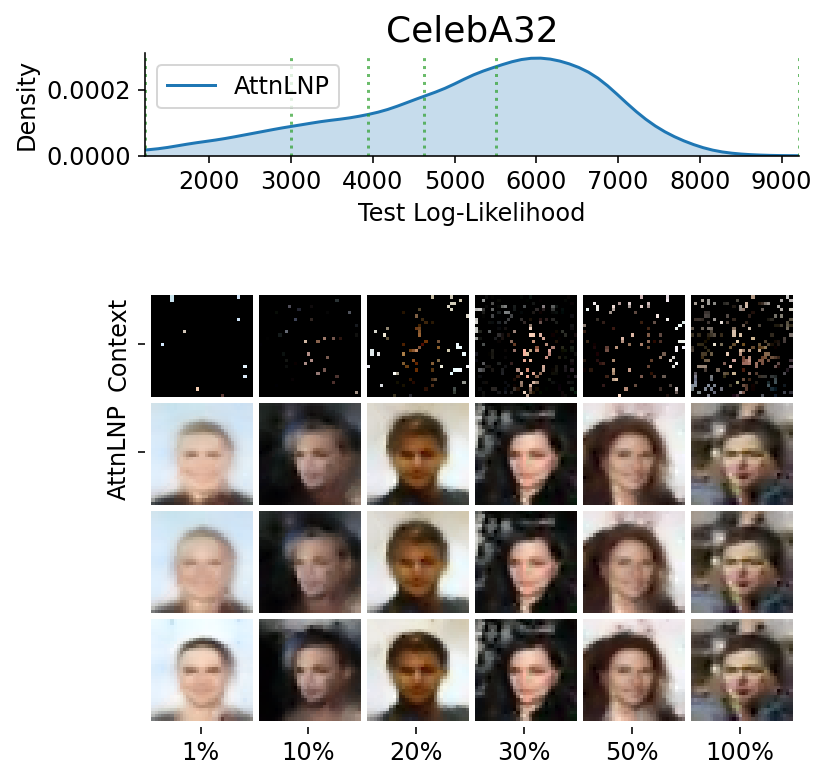

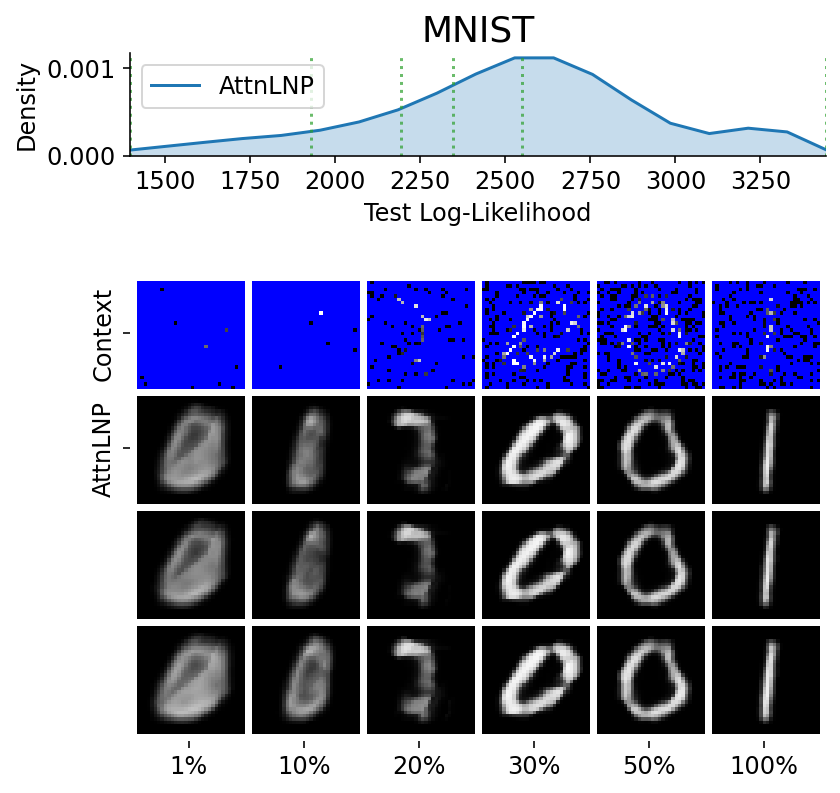

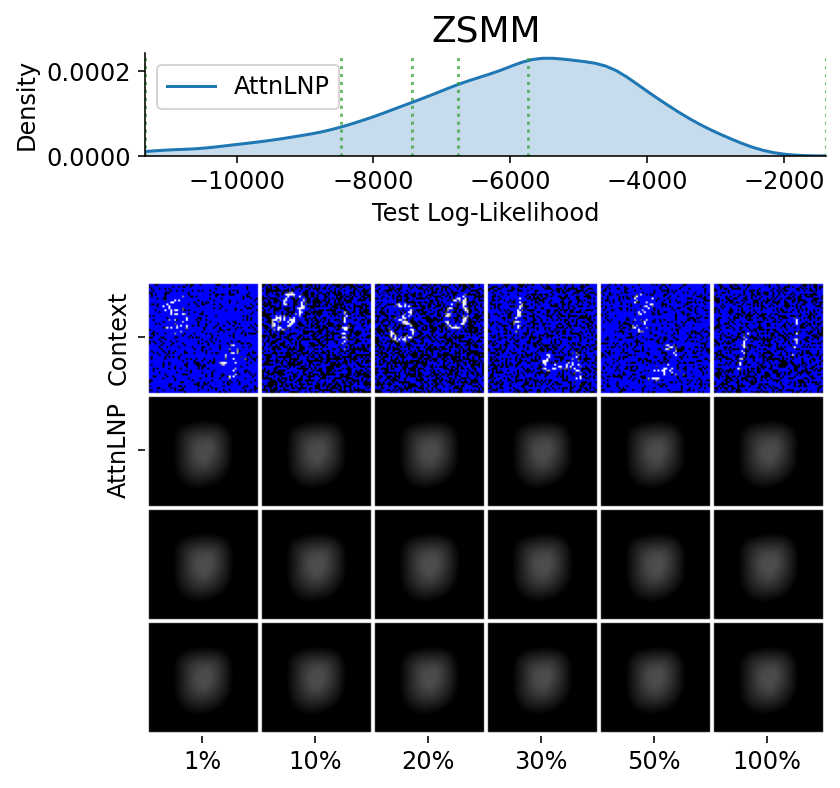

In [12]:
from utils.ntbks_helpers import PRETTY_RENAMER
from utils.visualize import plot_qualitative_with_kde


n_trainers = len(trainers_2d)
for i, (k, trainer) in enumerate(trainers_2d.items()):
    data_name = k.split("/")[0]
    model_name = k.split("/")[1]
    dataset = img_test_datasets[data_name]

    plot_qualitative_with_kde(
        [PRETTY_RENAMER[model_name], trainer],
        dataset,
        figsize=(6, 6),
        percentiles=[1, 10, 20, 30, 50, 100],  # desired test percentile
        height_ratios=[1, 6],  # kde / image ratio
        is_smallest_xrange=True,  # rescale X axis based on percentile
        h_pad=0,  # padding
        title=PRETTY_RENAMER[data_name],
        upscale_factor=get_test_upscale_factor(data_name),
        n_samples=3,
    )